In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("lab6.ipynb")

---

<h1><center>SDSE Lab 6 <br><br> Ensemble methods and hyperparameter tuning </center></h1>

---




In this lab exercise we will apply several classification models to a problem in astrophysics. The problem is described [here](https://satyam5120.medium.com/predicting-a-pulsar-star-using-different-machine-learning-algorithms-d22ee8fc71b4) and [here](https://www.kaggle.com/datasets/colearninglounge/predicting-pulsar-starintermediate). It consists in labeling observations of space objects as either pulsars or not pulsars, based on the properties of an 'integrated profile' and on the DM-SNR curve. The dataset has 8 feature columns:
1. Mean of the integrated profile.
2. Standard deviation of the integrated profile.
3. Excess kurtosis of the integrated profile.
4. Skewness of the integrated profile.
5. Mean of the DM-SNR curve.
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve.
8. Skewness of the DM-SNR curve.

Our goal is to choose a classification model from amongst the ones we've learned in class. The procedure will follow these steps:
1. Load the data.
2. Visually inspect histograms, box plots, and the correlation matrix.
3. Find number of samples per class.
4. Extract a test dataset.
5. Build models:
    + Logistic regression
    + Support vector machine
    + Random forest
    + AdaBoost
    + Gradient Boosted Trees
6. Select and evaluate a final model.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lab6_utils as lab6
rng_seed = 2434

# 1. Load the data

+ Load the data file `pulsar_data.csv` into a Pandas dataframe using [`pd.read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)
+ Save the column headers corresponding to feature names to the variable `feature_names` ([Hint](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.columns.html))

In [4]:
df = pd.read_csv('pulsar_data.csv')
feature_names = df.columns.values[:-1]

In [5]:
grader.check("q1")

q1 results: All test cases passed!

# 2. Remove null values

+ Save the number of nulls in each column into a dictionary called `numnulls_in_feature`. This dictionary has been initialized for you with the feature names as keys, and all values set to 0.
+ Remove from the DataFrame all columns (other than the `target_class` column) with more than zero null values. 
+ Also remove these names from `feature_names`.

In [6]:
numnulls_in_feature = dict().fromkeys(feature_names,0)
for feature in feature_names:
    numnulls_in_feature[feature] = df[feature].isna().sum()
df = df.dropna(axis=1)
feature_names = df.columns.values[:-1]

In [7]:
grader.check("q2")

q2 results: All test cases passed!

# 3. Number of samples per class

Find the number of data points in each of the two classes. Save the number of class 0 data and class 1 data to `N0` and `N1` respectively. Notice that there is a significant imbalance of negative and positive samples in this dataset. 

In [8]:
N0 = (df['target_class'] == 0).sum()
N1 = (df['target_class'] == 1).sum()

In [9]:
grader.check("q3")

q3 results: All test cases passed!

# 4. Extracting the test dataset

Split the dataset contained in `df` into trainging and testing parts, with 90% used for training and 10% for testing. Remember to set the `random_state` to `rng_seed`.

In [10]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(df.iloc[:,:-1],
                                                df['target_class'],
                                                test_size=0.1,
                                                random_state=rng_seed )

In [11]:
grader.check("q4")

q4 results: All test cases passed!

# 5. Models

## 5.1 Logistic regression 

### 5.1.1. Training

In this part we will use grid search to choose the values of the hyperparameters of the logistic regression pipeline. Begin by creating a pipeline with a `StandardScaler` followed by `LogisticRegression` classifier. Pass these parameters to the contructor of the logistic regression classifier:
+ `solver`: `liblinear`
+ `random_state`: `rng_seed`

Then fit the model using the training data.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model = Pipeline([
    ('scaler', StandardScaler()) ,
    ('model', LogisticRegression(  #C=1,
                                    #penalty='l1',
                                    solver='liblinear',
                                    #max_iter=1000,
                                    random_state=rng_seed))
])
model.fit(Xtrain, ytrain)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(random_state=2434, solver='liblinear'))])

In [13]:
grader.check("q5p1p1")

q5p1p1 results: All test cases passed!

### 5.1.2. Hyperparameter tuning with grid search

Run grid search (see documentation here: [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) with 3-fold cross validation. The parameters to search over are:

+ the regularization function `penalty`. Candidate values are `l1` and `l2`
+ the regularization weight `C`. Candidate values are `np.logspace(-8, 1, 10)`.

Note, for `GridSearchCV` to work with the pipeline, it needs to set the parameters of the model using their string names. Within the pipeline, the parameters of the model are prefixed with `model__`. Hence, to set the penalty of logistic regression to `l1` or `l2`, you must include key-value pair `model__penalty : ['l1','l2']` in `param_grid`.

Pass the following parameters to the `GridSearchCV` contructor.
+ `scoring=['accuracy','recall']`,
+ `cv=cvfolds`,
+ `refit='recall'`

In [14]:
from sklearn.model_selection import GridSearchCV
cvfolds = 3
param_grid = {
    'model__penalty' : ['l1','l2'],                    # SHOULD BE MODEL__PENALTY
    'model__C' : np.logspace(-8, 1, 10) }              # SHOULD BE MODEL__C
gs = GridSearchCV(  estimator=model,
                    param_grid=param_grid,
                    scoring=['accuracy','recall'],
                    cv=cvfolds,
                    refit='recall'
)
gs = gs.fit(Xtrain,ytrain)


`lab6_utils.py` contains useful functions for unpacking and plotting the result of the grid search. Use the `unpack_gridsearch` method to extract useful information from the grid search solution. This method returns:
1. A pandas dataframe with the cross-validated performance metrics for each point on the grid.
2. A dictionary with the best-case hyperparameter values
3. The classifier with best-case hyperparameters assigned


In [16]:
result_logreg, best_params_logreg, best_model_logreg, best_score_logreg = lab6.unpack_gridsearch(gs,param_grid,cvfolds)

`plot_grid_result` plots the results of the grid search.

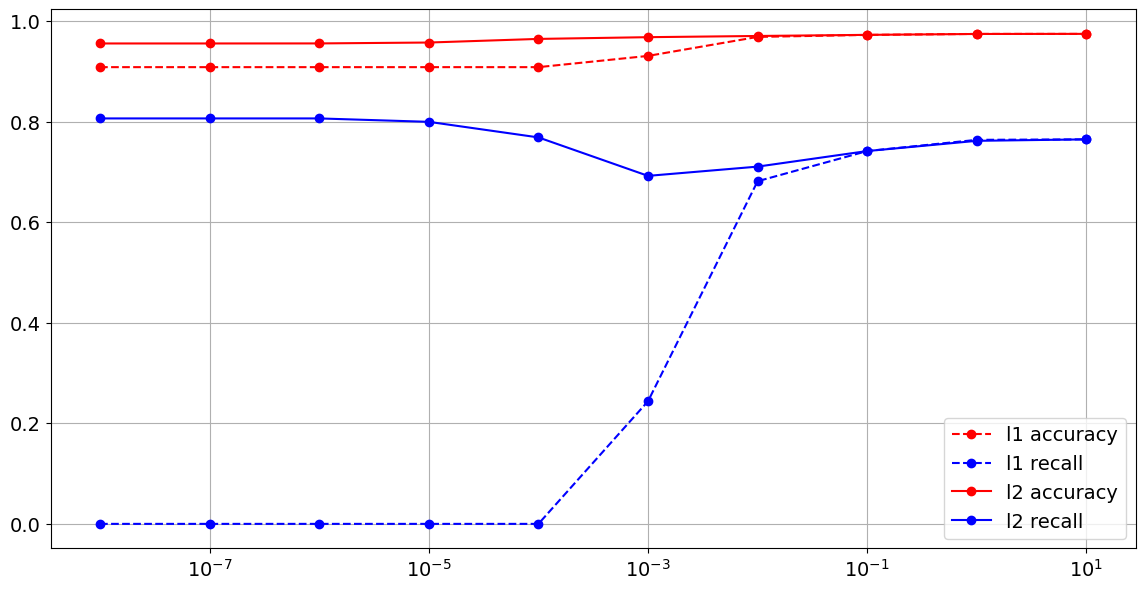

In [17]:
lab6.plot_grid_result(result_logreg,param_grid)

In [18]:
grader.check("q5p1p2")

q5p1p2 results: All test cases passed!

### 5.1.3. Package it into a function

Next we will repeat this process with several other classification models. To keep the code clean, you should collect the steps into a single function. This function should receive as inputs:
1. The classifier object, e.g. `LogisticRegression(solver='liblinear',random_state=rng_seed)`
2. The `param_grid` dictionary that defines the search space for `GridSearchCV`.

It should:
1. Create the pipeline model
2. Construct the `GridSearchCV` object
3. Run `fit` on the grid search object, using the training data (no need to pass the data as an argument to `build_grid_plot`; it's a global variable)
4. Run `unpack_gridsearch` to obtain `result`, `best_params`, `best_model`, and `best_score`.
5. Plot the result with `lab6.plot_grid`
6. `return result, best_params, best_model, best_score`

In [19]:


def build_grid_plot(model,param_grid):

    global Xtrain, ytrain, cvfolds

    # Create the pipeline model
    model_pipeline = Pipeline([
    ('scaler', StandardScaler()) ,
    ('model', model)

    ])

    gs = GridSearchCV( model_pipeline,
                    param_grid=param_grid,
                    scoring=['accuracy','recall'],
                    cv=cvfolds,
                    refit='recall'
    )
    gs = gs.fit(Xtrain,ytrain)

    result, best_params, best_model, best_score = lab6.unpack_gridsearch(gs,param_grid,cvfolds)

    return result, best_params, best_model, best_score

# Additional models
Next we will repeat the exercise for four additional model types: SVMs, Random forests, AdaBoost, and Gradient boosted trees. In each case, use the suggested parameter grid. **Remember to always set the random state for the model in the model's constructor.**

# 5.2. Support vector machine

+ `kernel: ['poly','rbf']`
+ `C: np.logspace(-2, 2, 5)`

In [20]:
%%time
from sklearn.svm import SVC

param_grid_svm = {
    'model__kernel' : ['poly', 'rbf'],
    'model__C' : np.logspace(-2, 2, 5)}

result_svc, best_params_svc, best_model_svc, best_score_svc = build_grid_plot(SVC(random_state=rng_seed), param_grid_svm)

CPU times: total: 47.2 s
Wall time: 47.3 s


In [21]:
grader.check("q5p2")

q5p2 results: All test cases passed!

# 5.3. Random forest

+ `max_features: ['sqrt','log2']`
+ `n_estimators: np.linspace(2, 100, 5, dtype=int)`

In [22]:
%%time
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'model__max_features' : ['sqrt', 'log2'],
    'model__n_estimators' : np.linspace(2, 100, 5, dtype=int)}

result_rf, best_params_rf, best_model_rf, best_score_rf = build_grid_plot(RandomForestClassifier(random_state=rng_seed), param_grid_rf)

CPU times: total: 19.3 s
Wall time: 19.5 s


In [23]:
grader.check("q5p3")

q5p3 results: All test cases passed!

# 5.4. AdaBoost

+ `learning_rate: [0.01,0.1]`
+ `n_estimators: np.linspace(10, 100, 5, dtype=int)`

In [24]:
%%time
from sklearn.ensemble import AdaBoostClassifier

param_grid_ab =  {
    'model__learning_rate' : [0.01, 0.1],
    'model__n_estimators' : np.linspace(10, 100, 5, dtype=int)}

result_ab, best_params_ab, best_model_ab, best_score_ab = build_grid_plot(AdaBoostClassifier(random_state=rng_seed), param_grid_ab)

CPU times: total: 14.1 s
Wall time: 14.3 s


In [25]:
grader.check("q5p4")

q5p4 results: All test cases passed!

# 5.5. Gradient Boosted Trees

+ `learning_rate: [0.1,1.0]`
+ `n_estimators: [50,75,100]`

In [26]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbc = {
    'model__learning_rate' : [0.1, 1.0],
    'model__n_estimators' : [50, 75, 100]}

result_gbc, best_params_gbc, best_model_gbc, best_score_gbc = build_grid_plot(GradientBoostingClassifier(random_state=rng_seed), param_grid_gbc)

CPU times: total: 19 s
Wall time: 19.3 s


In [27]:
grader.check("q5p5")

q5p5 results:
    q5p5 - 1 result:
        ✅ Test case passed

    q5p5 - 2 result:
        ❌ Test case failed
        Trying:
            np.allclose(np.sort(result_gbc[0.1]['mean_test_recall'].to_numpy(dtype=float)),[0.80541512, 0.80735311, 0.81026008]      ,1e-3)
        Expecting:
            True
        **********************************************************************
        Line 1, in q5p5 1
        Failed example:
            np.allclose(np.sort(result_gbc[0.1]['mean_test_recall'].to_numpy(dtype=float)),[0.80541512, 0.80735311, 0.81026008]      ,1e-3)
        Expected:
            True
        Got:
            False

    q5p5 - 3 result:
        ✅ Test case passed

    q5p5 - 4 result:
        ✅ Test case passed

    q5p5 - 5 result:
        ✅ Test case passed

# 6. Final model selection

Select the classifier with the largest recall obtained from the grid search. Store its name, the model, and its recall score. These are listed in `all_models`.

Then compute the test accuracy and recall and store them as `final_accuracy` and `final_recall`.

In [28]:
from sklearn.metrics import accuracy_score, recall_score

all_models = [
    ('logreg',best_model_logreg, best_score_logreg),
    ('svc',best_model_svc, best_score_svc),
    ('rf',best_model_rf, best_score_rf),
    ('ab',best_model_ab, best_score_ab),
    ('gbc',best_model_gbc, best_score_gbc),
]

best_name, best_model, best_score = all_models[0]

for model in all_models:
    if model[2] > best_score:
        best_name, best_model, best_score = model
ypred = best_model.predict(Xtest)
final_accuracy = accuracy_score(ytest, ypred)
final_recall = recall_score(ytest, ypred)

In [29]:
grader.check("q6")

q6 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [30]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)